- **GPU Acceleration**

In [2]:
# import cuml.accel
# cuml.accel.install()

# Imports

In [3]:
import pathlib
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef)
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.ensemble import BalancedBaggingClassifier
from dd_hybrid_sampler import DDHybridSampler
from cost_sensitive import OverBoostClassifier

from pathlib import Path

# Dataset Listing and Loading

In [4]:
def read_data(path: Path):
    if path.suffix == ".csv":
        return pd.read_csv(path)
    else:                       # Excel
        return pd.read_excel(path)

- Dataset path:

In [5]:
DATA_DIR   = Path("datasets")    # CSV files
CSV_FILES  = sorted(DATA_DIR.glob("*.csv"))
assert CSV_FILES, "No CSV found"


- Result save path

In [6]:
OUT_DIR = pathlib.Path("output")
OUT_DIR.mkdir(exist_ok=True, parents=True)

- All avalable datasets:

In [7]:
for i, f in enumerate(CSV_FILES):
    print(i ,f.name)

0 abc3_oqmd_cs.csv
1 perov_form.csv
2 perov_stab.csv


In [8]:
for f in CSV_FILES:
    df = read_data(f)
    df_type = pd.DataFrame(df.dtypes, columns=["Data Type"])
    df_type.to_csv(OUT_DIR/f"{f.stem}_dtypes.csv")
    print(f.stem)
    display(df_type)
    # print(dir(df))

abc3_oqmd_cs


,Data Type
z_mean,float64
grp_mean,float64
row_mean,float64
pet_mn_mean,float64
mn_mean,float64
iupac_mean,float64
av_ionrad_mean,float64
atom_rad_mean,float64
cal_atom_rad_mean,float64
cov_rad_mean,float64


perov_form


,Data Type
t,float64
μ,float64
μĀ,float64
μ𝐵 ̅,float64
A_HOMO-,float64
A_HOMO+,float64
A_IE-,float64
A_IE+,float64
A_LUMO-,float64
A_LUMO+,float64


perov_stab


,Data Type
t,float64
μ,float64
μĀ,float64
μ𝐵 ̅,float64
A_HOMO-,float64
A_HOMO+,float64
A_IE-,float64
A_IE+,float64
A_LUMO-,float64
A_LUMO+,float64


# Machine Learning Pipeline

## ML Model

In [9]:

CV         = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
CLASSIFIER = RandomForestClassifier(n_estimators=300,
                                    n_jobs=-1,
                                    random_state=42)


## Sampling Algorithms

In [10]:

SAMPLERS   = {
    "None"          : None,
    "SMOTE"         : SMOTE(random_state=42),
    "OverSample"    : RandomOverSampler(random_state=42),
    "DownSample"    : RandomUnderSampler(random_state=42),
    "SMOTE_Bagging" : BalancedBaggingClassifier(random_state=84, sampler = SMOTE(random_state=100, k_neighbors=2)),
    "CNN"           : CondensedNearestNeighbour(random_state=10, n_jobs=-1),
    "NC"            : NeighbourhoodCleaningRule(),
    # "ICost"         : OverBoostClassifier(random_state=84),
    "DD_Hybrid"     : DDHybridSampler(target_ir=1.5, k=5, random_state=42)
}

SAMPLE_MODEL = ["ICost", "SMOTE_Bagging"]

## Model Metrics

In [11]:

METRICS    = ["accuracy", "macro_precision", "macro_recall", "macro_f1",
              "weighted_precision", "weighted_recall", "weighted_f1", "mcc"]

## Model Pipeline

In [12]:
def build_pipeline(sampler, classifier=CLASSIFIER) -> ImbPipeline:
    steps = [
        ("impute", SimpleImputer(strategy="median")),
        ("scale" , StandardScaler()),          # optional but cheap
    ]
    if sampler is not None:
        steps.append(("sample", sampler))
    steps.append(("clf", classifier))
    return ImbPipeline(steps)

## Scoring function

In [13]:
def score_fold(y_true, y_pred, NAN=False) -> dict:
    if NAN:
        return {
            "accuracy"          : np.nan,
            "macro_precision"   : np.nan,
            "macro_recall"      : np.nan,
            "macro_f1"          : np.nan,
            "weighted_precision": np.nan,
            "weighted_recall"   : np.nan,
            "weighted_f1"       : np.nan,
            "mcc"               : np.nan,
        }
    return {
        "accuracy"          : accuracy_score(y_true, y_pred),
        "macro_precision"   : precision_score(y_true, y_pred,
                                              average="macro", zero_division=0),
        "macro_recall"      : recall_score(y_true, y_pred,
                                           average="macro", zero_division=0),
        "macro_f1"          : f1_score(y_true, y_pred,
                                       average="macro", zero_division=0),
        "weighted_precision": precision_score(y_true, y_pred,
                                              average="weighted", zero_division=0),
        "weighted_recall"   : recall_score(y_true, y_pred,
                                           average="weighted", zero_division=0),
        "weighted_f1"       : f1_score(y_true, y_pred,
                                       average="weighted", zero_division=0),
        "mcc"               : matthews_corrcoef(y_true, y_pred),
    }

# Master loop – run pipelines

For all Datasets
- Loading Dataset
- Label Encoding
- Loop for all Sampling Algorithms
- Build Pipeline
- Train-Test model with StratifiedkFold
- Save the scores

In [14]:
def imbalance_ratio(y):
    """
    y : 1-D numpy array of class labels
    returns IR (float) = majority_count / minority_count
    """
    counts = np.bincount(y)          # works for integer-encoded labels
    return counts.max() / counts.min()

In [15]:
# # scores = {m: {s: {} for s in SAMPLERS} for m in METRICS}   # metric -> sampler -> dataset -> score
# scores = {m: {**{name: {} for name in SAMPLERS},   # real samplers
#             'IR': {}}                            # IR slot
#             for m in METRICS}

# total_dataset = len(CSV_FILES)
# for di, dataset_path in enumerate(CSV_FILES):
#     ds_name = dataset_path.stem
#     print(f"\n{di}/{total_dataset} - Processing {ds_name}" , end="\t\t")
    
#     # load + basic cleaning
#     df = read_data(dataset_path)
#     df = df.dropna(subset=[df.columns[-1]])
#     if df.shape[0] < 20:
#         print("Too few samples (<20). Skipping...")
#         continue
#     print("Target Size = ", df.shape, "\t", "No. of classes = ", df.iloc[:, -1].nunique())

#     X = df.iloc[:, :-1].copy()
#     y = LabelEncoder().fit_transform(df.iloc[:, -1])

    
#     cat_cols = X.select_dtypes(exclude=np.number).columns
#     if len(cat_cols):
#         X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    
    

#     for samp_name, sampler in SAMPLERS.items():
#         print("\t- Performing Cross-Validation on : ", samp_name)
#         if samp_name in SAMPLE_MODEL:
#             pipe = build_pipeline(None, classifier=sampler)
#         else:
#             pipe = build_pipeline(sampler)
#         fold_scores = {m: [] for m in METRICS}
        
#         for train_idx, val_idx in CV.split(X, y):
#             X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#             y_train, y_val = y[train_idx], y[val_idx]
            
#             pipe.fit(X_train, y_train)          # ALL steps fitted only on train
#             y_pred = pipe.predict(X_val)
            
#             for k, v in score_fold(y_val, y_pred).items():
#                 fold_scores[k].append(v)
        
#         # mean across folds
#         for m in METRICS:
#             scores[m]["IR"][ds_name] = imbalance_ratio(y)
#             scores[m][samp_name][ds_name] = np.mean(fold_scores[m])

In [16]:
pipe = build_pipeline("SMOTE")
clf = pipe[-1]
print(hasattr(pipe[-1], 'n_neighbors'))
dir(clf)

False


['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_request_for_signature',
 '_compute_oob_predictions',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_estimator_type',
 '_get_default_requests',
 '_get_doc_link',
 '_get_estimators_indices',
 '_get_metadata_request',
 '_get_oob_predictions',
 '_get_param_names',
 '_get_params_html',
 '_html_repr',
 '_make_estimator',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_o

In [17]:
CACHE_FILE = pathlib.Path("cv_scores_cache.json")   # <── per-dataset results
CACHE_FILE.parent.mkdir(exist_ok=True)

# load previous runs (if any)
if CACHE_FILE.exists():
    with open(CACHE_FILE) as f:
        scores = json.load(f)
else:
    scores = {m: {**{name: {} for name in SAMPLERS}} for m in METRICS}
    scores["IR"] = {}

total_dataset = len(CSV_FILES)
for di, dataset_path in enumerate(CSV_FILES):
    ds_name = dataset_path.stem
    print(f"\n{di+1}/{total_dataset} – {ds_name}", end="\t")

    # ---------- skip if this dataset is already complete ----------
    already_done = all(
        ds_name in scores[m][samp] for samp in SAMPLERS for m in METRICS
        )


    skip_dataset = True
    if already_done:
        for metric in METRICS:
            df = pd.DataFrame(scores[metric])
            if df.loc[ds_name].isna().any():
                # print("Already cached – skipping.")
                skip_dataset = False
        
    if skip_dataset and already_done:
        print("Already cached – skipping.")
        continue


    # --------------------------------------------------------------

    # load + basic cleaning
    df = read_data(dataset_path)
    df = df.dropna(subset=[df.columns[-1]])
    if df.shape[0] < 20:
        print("Too few samples (<20). Skipping...")
        continue
    print("Shape =", df.shape, "Classes =", df.iloc[:, -1].nunique())

    X = df.iloc[:, :-1].copy()
    y = LabelEncoder().fit_transform(df.iloc[:, -1])
    cat_cols = X.select_dtypes(exclude=np.number).columns
    if len(cat_cols):
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    # store IR once
    ir = imbalance_ratio(y)
    for m in METRICS:
        scores['IR'][ds_name] = ir
    
    total_sampler = len(SAMPLERS)
    # ---------- cross-validation only for missing sampler/metric pairs ----------
    # for samp_name, sampler in SAMPLERS.items():
    for si, (samp_name, sampler) in enumerate(SAMPLERS.items(), start=1):
        missing_metrics = [m for m in METRICS if ds_name not in scores[m].get(samp_name, {})]
        # if not missing_metrics:
        #     print(f"\t- {samp_name} already cached – skipping.")
        #     continue

        if all(
            scores[m].get(samp_name, {}).get(ds_name) is not None
            and not np.isnan(scores[m][samp_name][ds_name])
            for m in METRICS
            ):
            print(f"\t- {samp_name} already cached & valid – skipping.")
            continue

        print(f"\t{si}/{total_sampler} | Performing StratifiedKFold on : {samp_name}")

        pipe = build_pipeline(sampler) if samp_name not in SAMPLE_MODEL else build_pipeline(None, classifier=sampler)
        fold_scores = {m: [] for m in METRICS}
        # Expected n_neighbors <= n_samples_fit, else skip
        # inside the fold loop (or just before fitting)

        
        for train_idx, val_idx in CV.split(X, y):
            X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]
            try:
                pipe.fit(X_tr, y_tr)
                y_pred = pipe.predict(X_val)
                _NAN = False
            except :
                _NAN = True
            if _NAN:
                res = {
                    "accuracy"          : np.nan,
                    "macro_precision"   : np.nan,
                    "macro_recall"      : np.nan,
                    "macro_f1"          : np.nan,
                    "weighted_precision": np.nan,
                    "weighted_recall"   : np.nan,
                    "weighted_f1"       : np.nan,
                    "mcc"               : np.nan,
                }
            else:
                res = score_fold(y_val, y_pred)
            for k, v in res.items():
                fold_scores[k].append(v)

        # # run stratified 5-fold CV in one call
        # cv_results = cross_validate(
        #     pipe, X, y,
        #     cv = CV,
        #     scoring = score_fold,
        #     n_jobs = -1
        #     )

        # # fold_scores is now the mean across folds for each metric
        # fold_scores = {m: cv_results[f'test_{m}'].mean() for m in score_fold}

        for m in missing_metrics:
            scores[m][samp_name][ds_name] = np.mean(fold_scores[m])

    # ---------- flush to disk after every dataset ----------
    with open(CACHE_FILE, "w") as f:
        json.dump(scores, f, indent=2)


1/3 – abc3_oqmd_cs	

Shape = (29209, 59) Classes = 7
	- None already cached & valid – skipping.
	- SMOTE already cached & valid – skipping.
	- OverSample already cached & valid – skipping.
	- DownSample already cached & valid – skipping.
	- SMOTE_Bagging already cached & valid – skipping.
	- CNN already cached & valid – skipping.
	- NC already cached & valid – skipping.
	8/8 | Performing StratifiedKFold on : DD_Hybrid

2/3 – perov_form	Already cached – skipping.

3/3 – perov_stab	Already cached – skipping.


# Results

- Scores

In [18]:
df_per_metric = {}
for metric in METRICS:
    df = pd.DataFrame(scores[metric])#.T   # samplers × datasets
    # df = df.T                             # datasets × samplers
    # df.name = metric
    # df_per_metric.append(df)
    df_per_metric[metric] = df

- Display Scores

In [19]:
for name, df in df_per_metric.items():
    print("="*80)
    print(name)
    display(df)
    print("")

accuracy


,None,SMOTE,OverSample,DownSample,SMOTE_Bagging,CNN,NC,DD_Hybrid
abc3_oqmd_cs,0.903317,0.900099,0.900955,0.705467,0.917765,0.723442,0.853436,NaN
perov_form,0.926246,0.914950,0.913621,0.866445,0.908970,0.884385,0.904319,0.916944
perov_stab,0.935139,0.933699,0.935428,0.930815,0.922745,0.920727,0.908622,0.935139



macro_precision


,None,SMOTE,OverSample,DownSample,SMOTE_Bagging,CNN,NC,DD_Hybrid
abc3_oqmd_cs,0.890646,0.869960,0.877844,0.584143,0.893382,0.627645,0.820771,NaN
perov_form,0.913819,0.879613,0.880652,0.799187,0.866535,0.822390,0.855917,0.886758
perov_stab,0.933442,0.931881,0.933494,0.928533,0.922287,0.919164,0.909090,0.933442



macro_recall


,None,SMOTE,OverSample,DownSample,SMOTE_Bagging,CNN,NC,DD_Hybrid
abc3_oqmd_cs,0.864475,0.873956,0.870073,0.759460,0.884254,0.663735,0.776584,NaN
perov_form,0.857802,0.861018,0.854445,0.865786,0.859433,0.857702,0.861132,0.858807
perov_stab,0.935374,0.934394,0.936153,0.933105,0.920652,0.925343,0.915723,0.935374



macro_f1


,None,SMOTE,OverSample,DownSample,SMOTE_Bagging,CNN,NC,DD_Hybrid
abc3_oqmd_cs,0.876577,0.871510,0.873422,0.617315,0.888229,0.642312,0.782499,NaN
perov_form,0.881557,0.869260,0.865826,0.822277,0.862509,0.836805,0.857915,0.870985
perov_stab,0.934237,0.932842,0.934587,0.930107,0.921345,0.920193,0.908284,0.934237



weighted_precision


,None,SMOTE,OverSample,DownSample,SMOTE_Bagging,CNN,NC,DD_Hybrid
abc3_oqmd_cs,0.902107,0.900131,0.900663,0.767757,0.917368,0.726971,0.857709,NaN
perov_form,0.925060,0.913861,0.912194,0.891976,0.908831,0.894482,0.905920,0.915716
perov_stab,0.935621,0.934482,0.936088,0.932575,0.922847,0.925351,0.917479,0.935621



weighted_recall


,None,SMOTE,OverSample,DownSample,SMOTE_Bagging,CNN,NC,DD_Hybrid
abc3_oqmd_cs,0.903317,0.900099,0.900955,0.705467,0.917765,0.723442,0.853436,NaN
perov_form,0.926246,0.914950,0.913621,0.866445,0.908970,0.884385,0.904319,0.916944
perov_stab,0.935139,0.933699,0.935428,0.930815,0.922745,0.920727,0.908622,0.935139



weighted_f1


,None,SMOTE,OverSample,DownSample,SMOTE_Bagging,CNN,NC,DD_Hybrid
abc3_oqmd_cs,0.902380,0.900019,0.900710,0.723209,0.917447,0.724154,0.843798,NaN
perov_form,0.923549,0.913872,0.912042,0.873433,0.908658,0.887672,0.904802,0.915429
perov_stab,0.935213,0.933801,0.935528,0.930999,0.922676,0.921016,0.908987,0.935213



mcc


,None,SMOTE,OverSample,DownSample,SMOTE_Bagging,CNN,NC,DD_Hybrid
abc3_oqmd_cs,0.874381,0.870466,0.871479,0.635717,0.893298,0.642498,0.811795,NaN
perov_form,0.769406,0.740114,0.734241,0.661487,0.725745,0.678853,0.716785,0.744664
perov_stab,0.868812,0.866270,0.869642,0.861625,0.842935,0.844484,0.824787,0.868812


In [20]:
for csv in CSV_FILES:
    df = pd.read_csv(csv)
    counts = df.iloc[:, -1].value_counts().sort_values(ascending=False)
    ir = counts.iloc[0] / counts.iloc[-1]
    print(f"{Path(csv).stem:<10}  IR = {ir:.2f}")

abc3_oqmd_cs  IR = 25.30
perov_form  IR = 3.73
perov_stab  IR = 1.29


# 7.  Bar-plots: % change vs SMOTE

- scores of SMOTE is set as baseline

accuracy


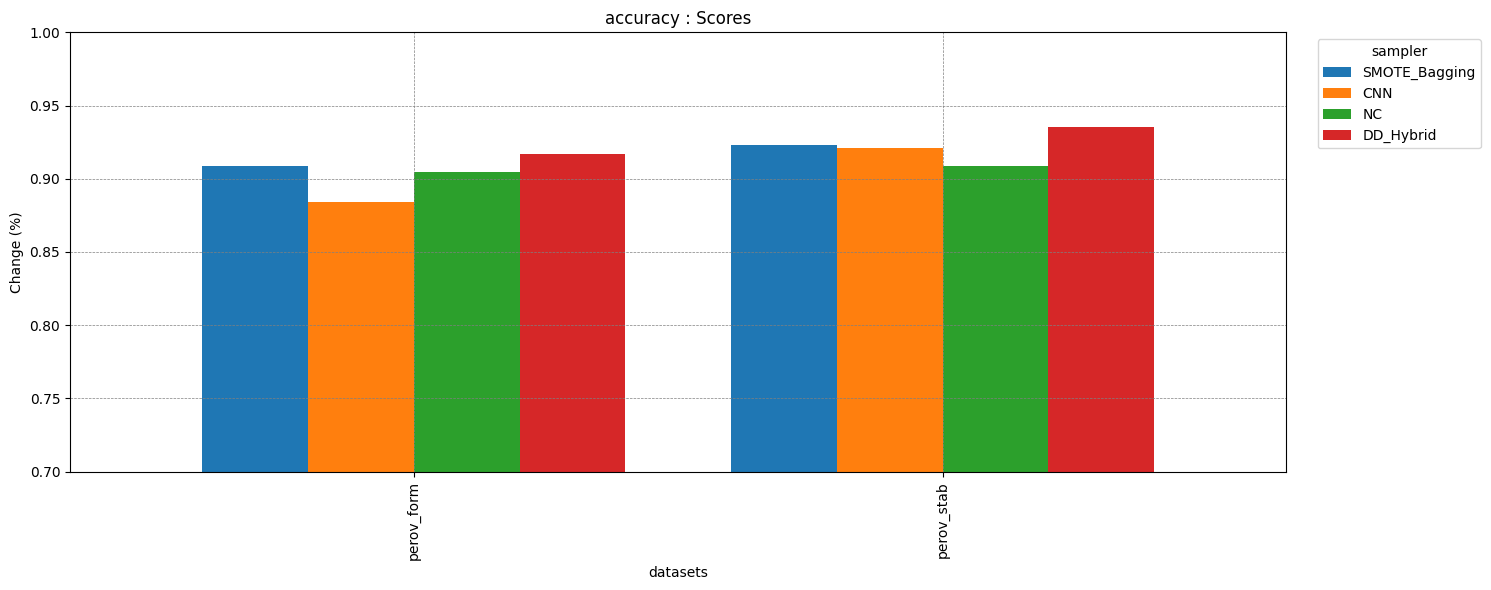

macro_precision


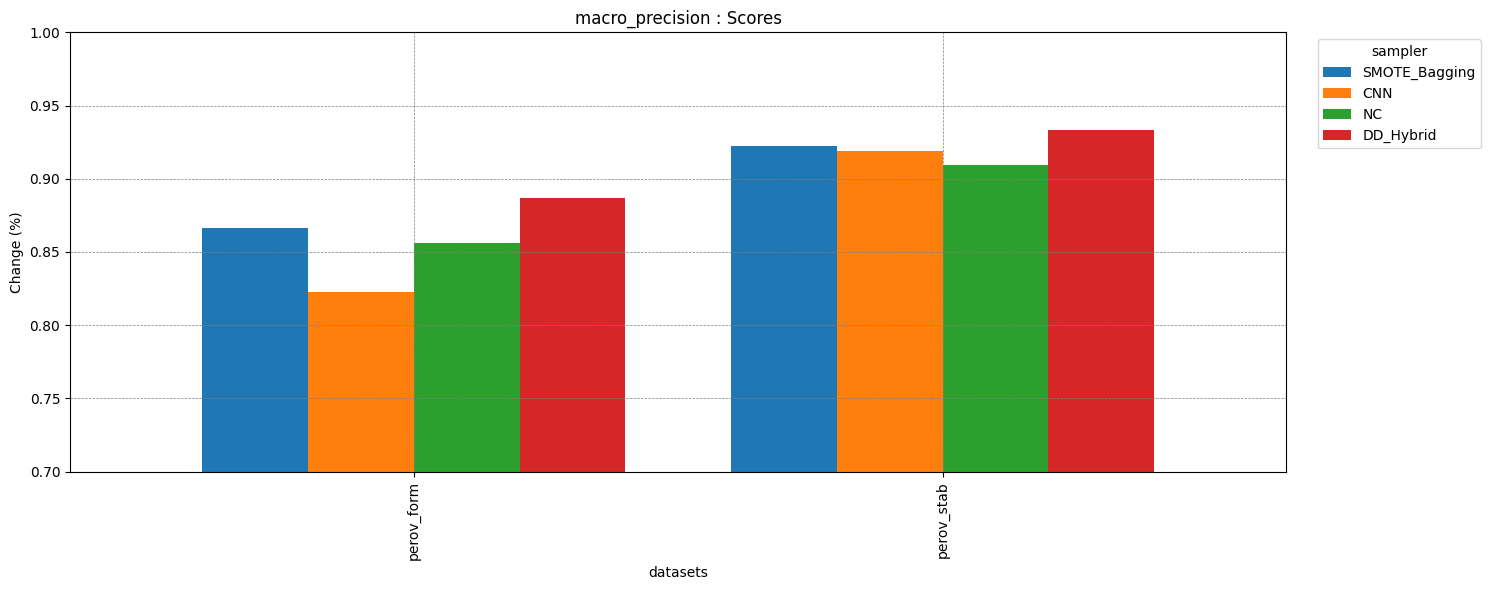

macro_recall


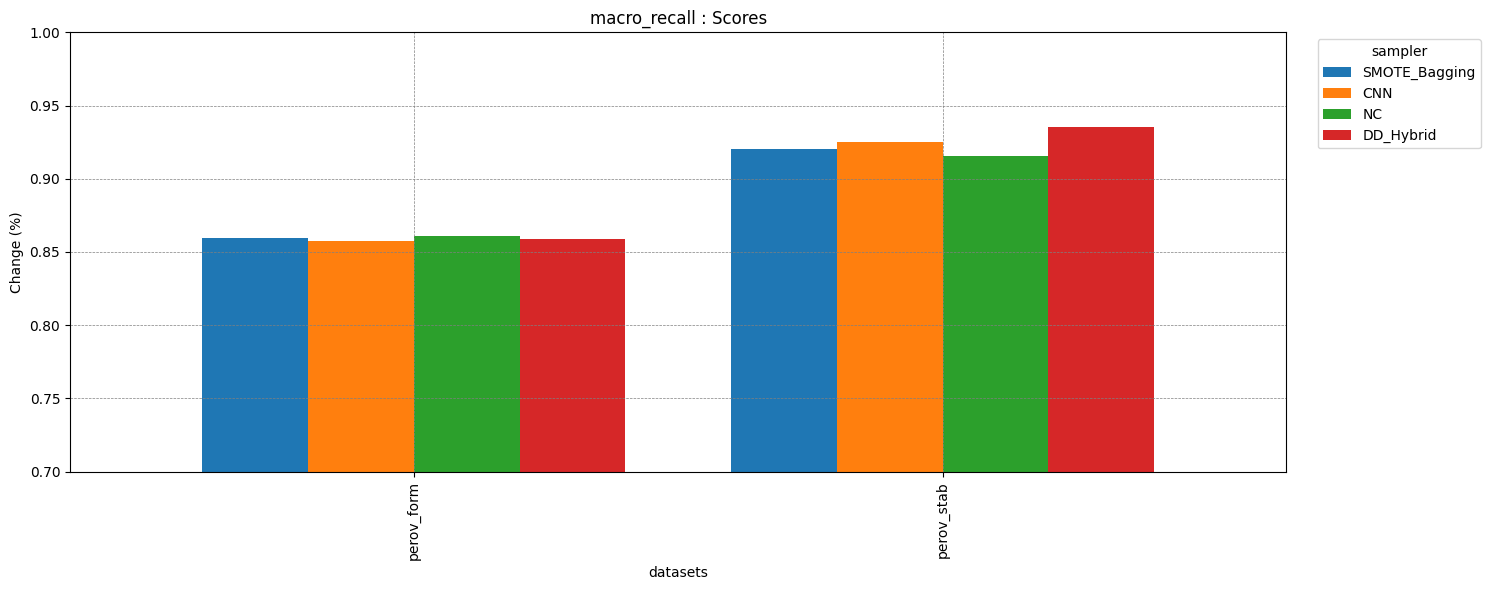

macro_f1


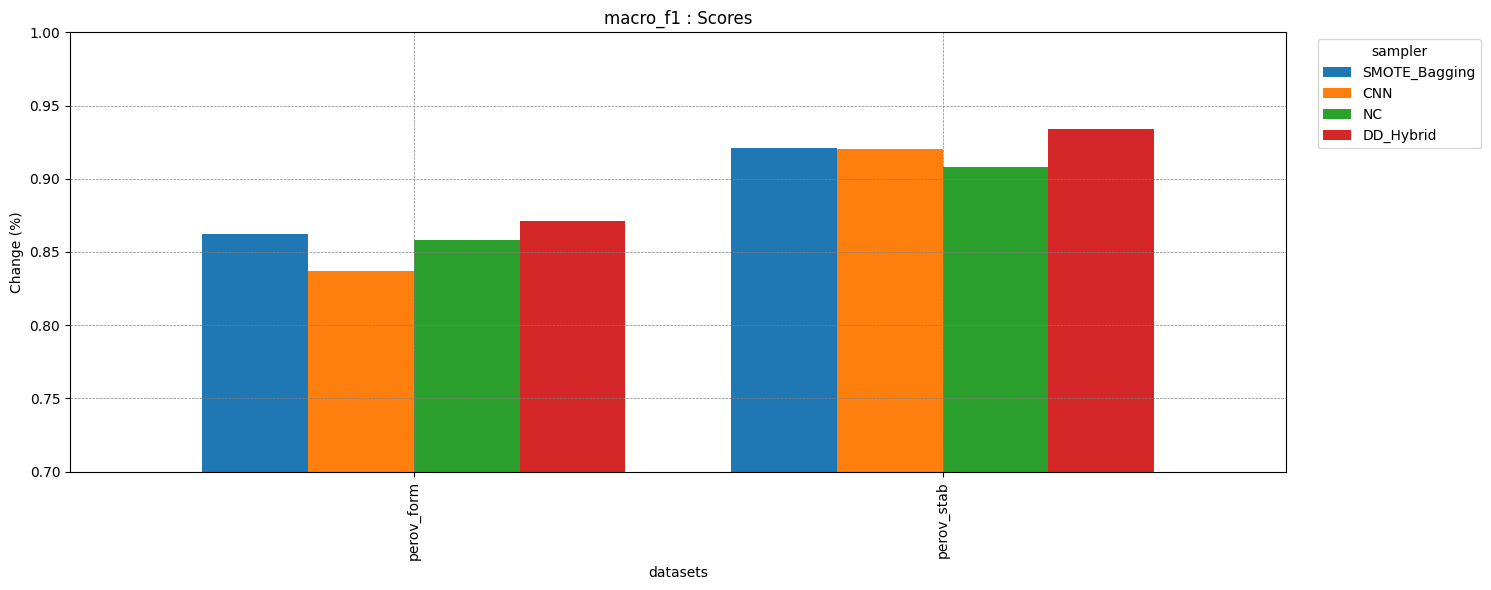

weighted_precision


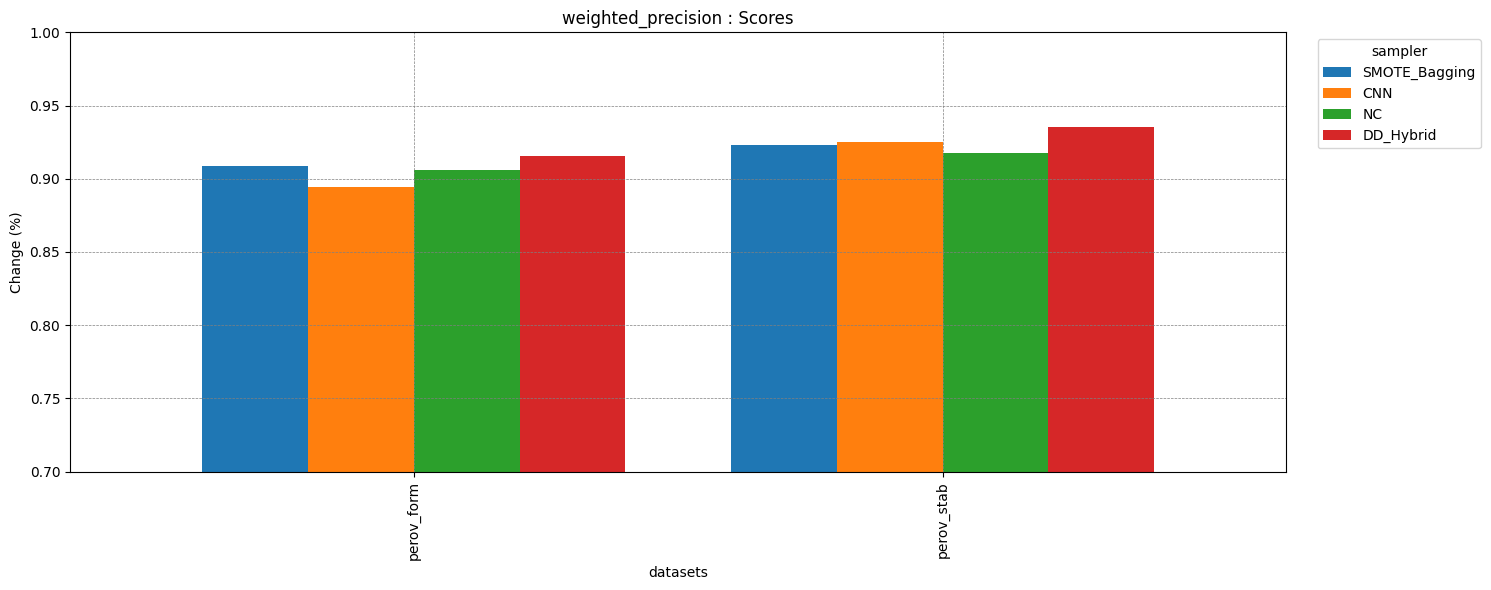

weighted_recall


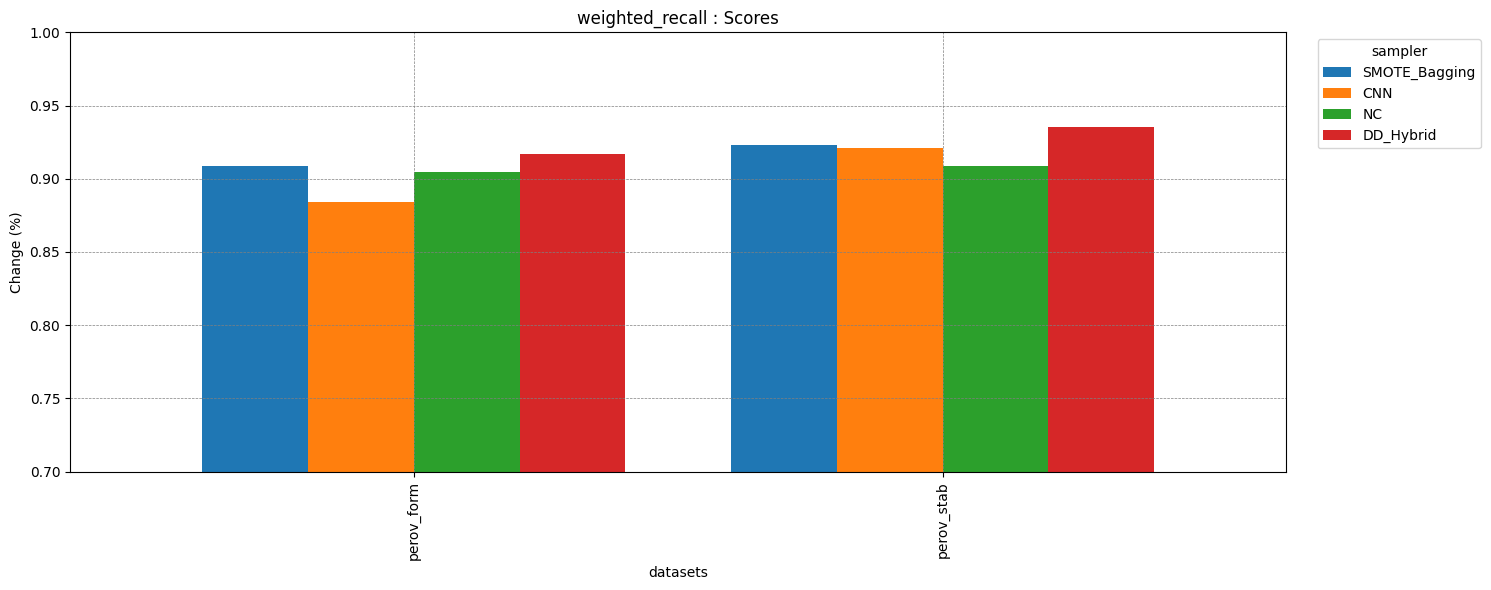

weighted_f1


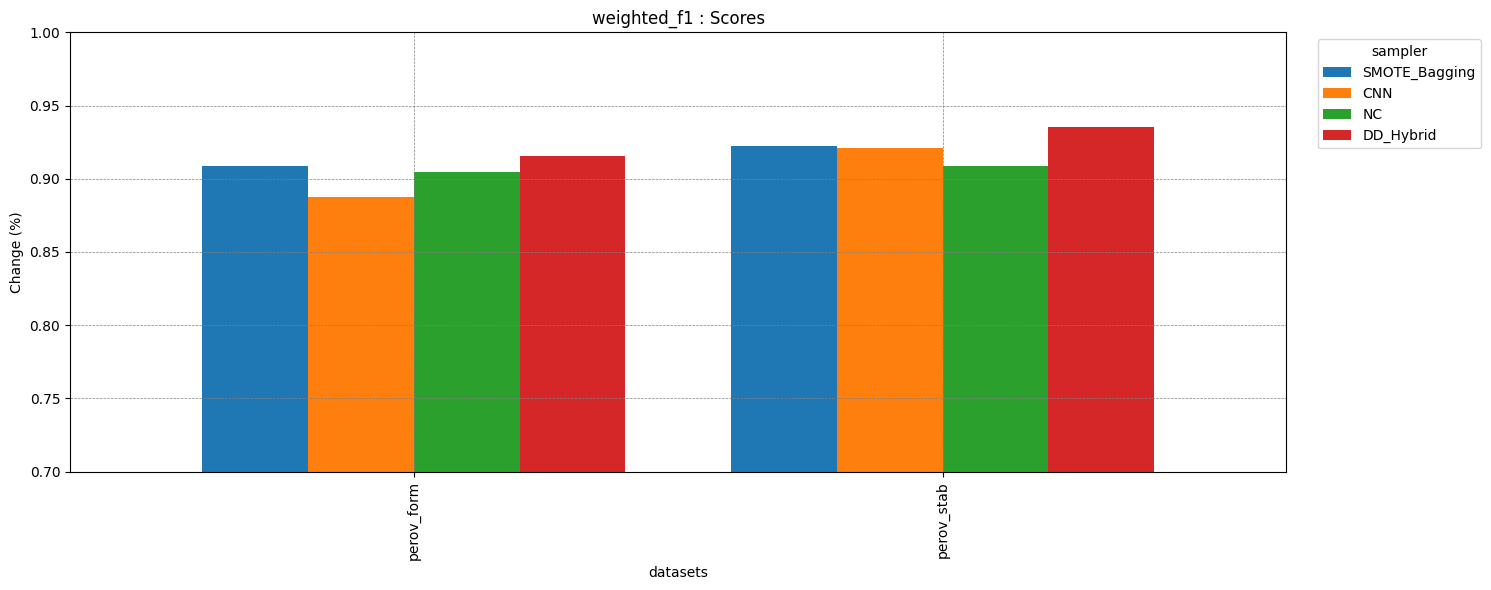

mcc


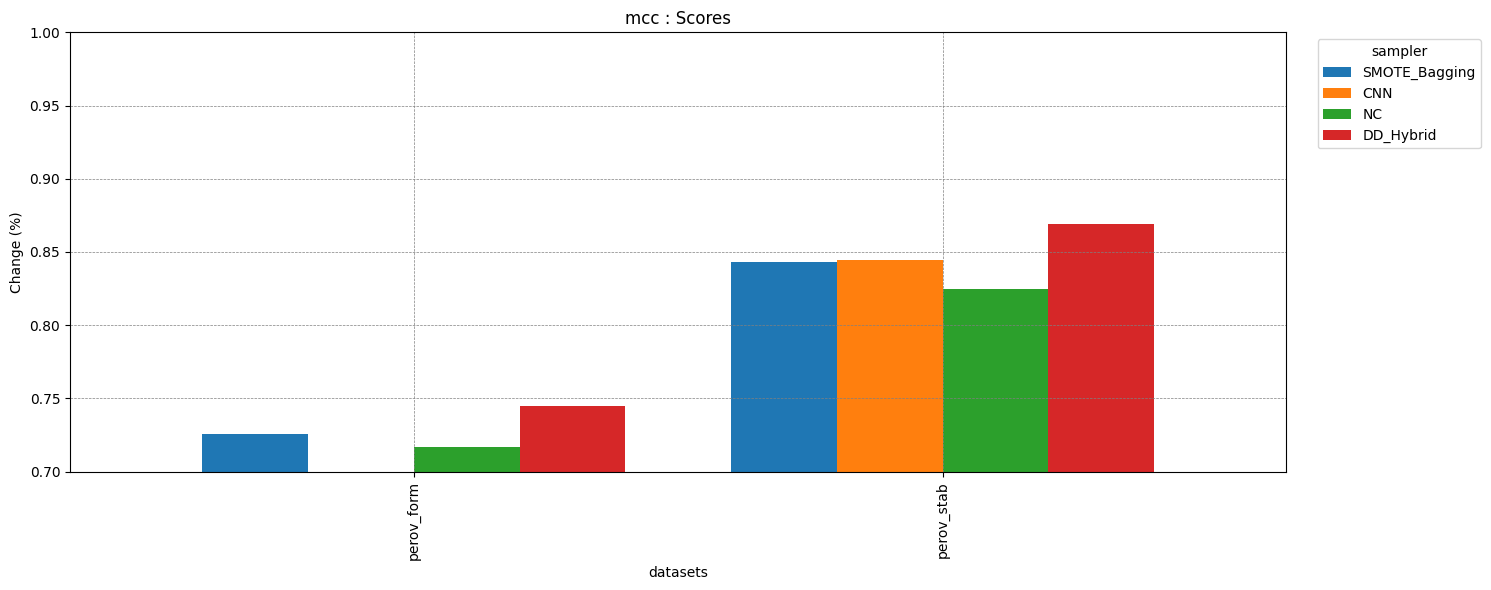

In [21]:
baseline = "DownSample"

# for df in df_per_metric:
for name, df in df_per_metric.items():
        print(name)
        # metric = df.name
        # df = df.dropna()

        # rel = ((df.subtract(df[baseline], axis=0)
        #         .div(df[baseline], axis=0))*100).round(2)
        # rel = rel.drop(columns=[baseline], errors="ignore")
        
        rel = df.drop(index="abc3_oqmd_cs", columns=["None", "OverSample", "DownSample", "SMOTE"]) 

        fig, ax = plt.subplots(figsize=(15, 6))
        rel.plot(kind="bar", ax=ax, width=0.8)
        ax.axhline(0, color="black", lw=0.8)
        ax.set_title(f"{name} : Scores")
        ax.set_ylabel("Change (%)")
        ax.set_xlabel("datasets")
        ax.legend(title="sampler", bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.ylim(0.7, 1.0)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
        plt.tight_layout()
        fig.savefig(OUT_DIR/f"{name}_result.png", dpi=300)
        plt.show()
        plt.close(fig)

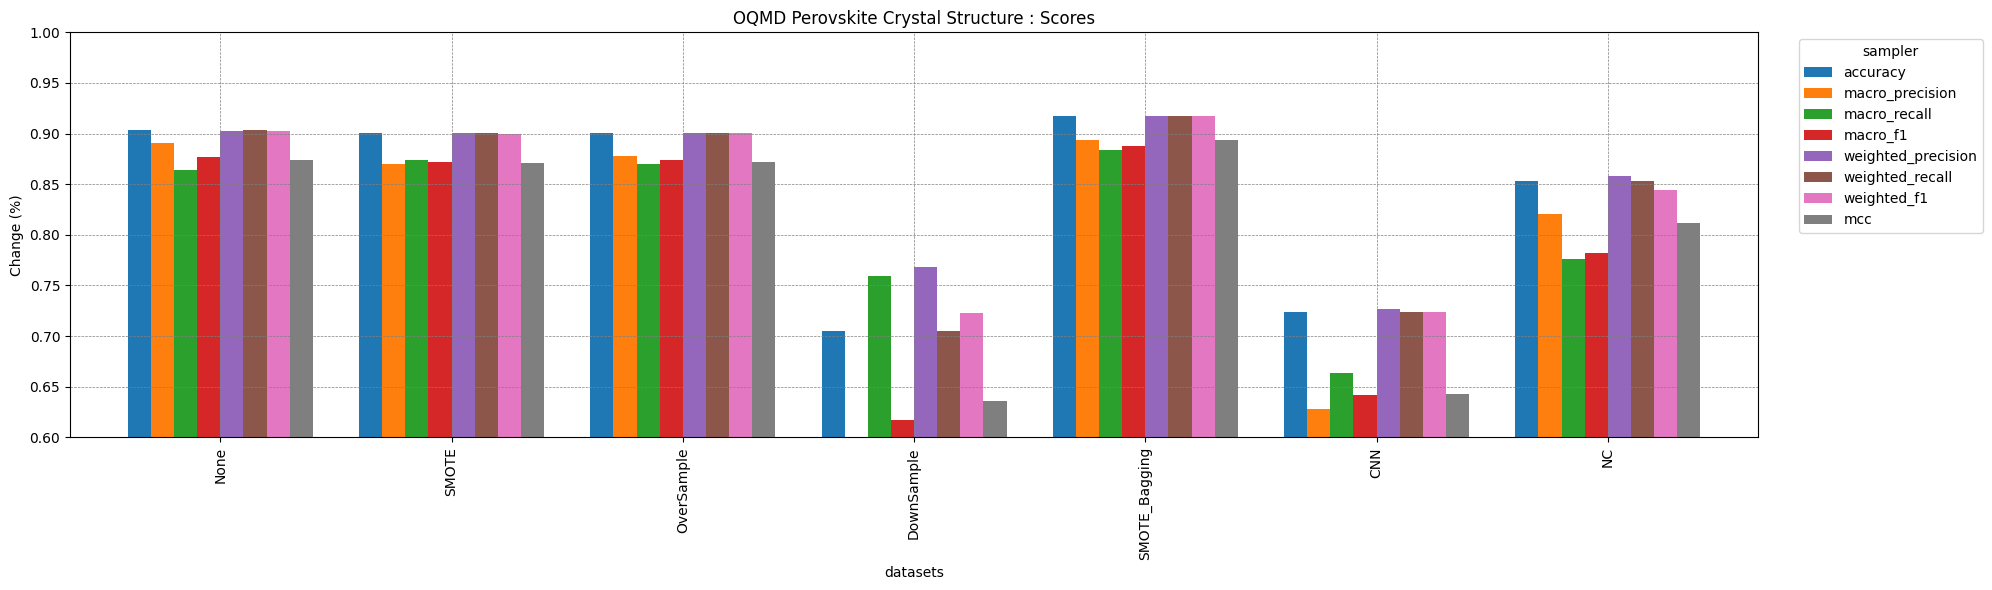

In [46]:
cs ={}
for name, df in df_per_metric.items():
        # print(name)
        cs[name] = df.loc["abc3_oqmd_cs"]
df_cs = pd.DataFrame(cs).dropna()

fig, ax = plt.subplots(figsize=(20, 6))
df_cs.plot(kind="bar", ax=ax, width=0.8)
ax.axhline(0, color="black", lw=0.8)
ax.set_title(f"OQMD Perovskite Crystal Structure : Scores")
ax.set_ylabel("Change (%)")
ax.set_xlabel("datasets")
ax.legend(title="sampler", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.ylim(0.6, 1.0)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.tight_layout()
fig.savefig(OUT_DIR/f"OQMD_result.png", dpi=300)
plt.show()
plt.close(fig)

In [42]:
# metric = "mcc"
# df = df_per_metric[metric]
# df = df.dropna()
# df = df.drop(columns=["IR"])
# rel = ((df.subtract(df[baseline], axis=0)
#         .div(df[baseline], axis=0))*100).round(2)
# rel = rel.drop(columns=[baseline], errors="ignore")

# fig, ax = plt.subplots(figsize=(10, 6))
# rel.plot(kind="bar", ax=ax, width=0.8)
# ax.axhline(0, color="black", lw=0.8)
# ax.set_title(f"{metric} : Change (%) vs {baseline}")
# ax.set_ylabel("Change (%)")
# ax.set_xlabel("datasets")
# ax.legend(title="sampler", bbox_to_anchor=(1.02, 1), loc="upper left")
# plt.tight_layout()
# fig.savefig(OUT_DIR/f"rel_vs_{baseline}_{metric}.png", dpi=300)
# plt.show()
# plt.close(fig)

In [43]:
# plt.figure(figsize=(12, 6))
# pd.Series(scores["IR"])[rel.index].plot(kind="bar", width=0.8)
# plt.xlabel("datasets")
# plt.title(f"IR of datasets")
# fig.savefig(OUT_DIR/f"IR_of_datasets.png", dpi=300)

# for name, df in df_per_metric.items():
#     df = df.dropna()
#     # df = df.drop(columns=["IR"])
#     rel = ((df.subtract(df[baseline], axis=0)
#             .div(df[baseline], axis=0))*100).round(2)
#     rel = rel.drop(columns=[baseline], errors="ignore")

#     for sampler in rel.columns:
#         fig, ax = plt.subplots(figsize=(10, 6))
#         rel[sampler].plot(kind="bar", ax=ax, width=0.8)

#         ax.set_title(f"{name} : {sampler} vs {baseline}")
#         ax.set_ylabel("Change (%)")
#         ax.set_xlabel("datasets")
#         plt.tight_layout()
#         fig.savefig(OUT_DIR/f"{name}_{sampler}_vs_{baseline}.png", dpi=300)
#         plt.show()
#         plt.close(fig)



# 8.  Export CSVs

In [44]:
# for df in df_per_metric:
for name, df in df_per_metric.items():
    IR = pd.Series(scores["IR"] , name="IR")
    df = pd.concat([IR, df], axis=1)
    df.to_csv(OUT_DIR/f"{name}.csv")

✅ **Completed**